In [1]:
from pope_model_api import *
from utils.draw_utils import draw_bbox_3d, draw_axis
%matplotlib inline
import matplotlib.pyplot as plt

layer_name: ['self', 'cross', 'self', 'cross', 'self', 'cross', 'self', 'cross']
layer_name: ['self', 'cross']


2024-05-08 10:57:42.201 | INFO     | pope_model_api:<module>:182 - load Matcher successfully


In [2]:
ckpt, model_type = get_model_info("h")
sam = sam_model_registry[model_type](checkpoint=ckpt)
DEVICE = "cuda"
sam.to(device=DEVICE)
MASK_GEN = SamAutomaticMaskGenerator(sam)
logger.info(f"load SAM model from {ckpt}")
crop_tool = CropImage()
dinov2_model = load_dinov2_model()
dinov2_model.to("cuda:0")

2024-05-08 10:57:50.713 | INFO     | __main__:<module>:6 - load SAM model from weights/sam_vit_h_4b8939.pth


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-11): 12 x NestedTensorBlock(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): DropPath()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): DropPath()
    )
  )
  (n

In [3]:
prompt = '1669-7'
target = '1639-7'
dataset_path = 'ycbv/'
path1 = '0801-7-other/'
path2 = '7-3/'

In [4]:
prompt_filename = 'data/' + dataset_path + path1 + path2 + 'color/' + prompt + '.png'
target_filename = 'data/' + dataset_path + path1 + path2 + 'color_full/' + target + '.png'
prompt_filename, target_filename

('data/ycbv/0801-7-other/7-3/color/1669-7.png',
 'data/ycbv/0801-7-other/7-3/color_full/1639-7.png')

In [5]:
# 相机内参矩阵
# K0是prompt的相机内参矩阵
K0 = np.loadtxt('data/' + dataset_path + path1 + path2 + 'intrin/' + prompt + '.txt')

# K1是target的相机内参矩阵
K1 = np.loadtxt('data/' + dataset_path + path1 + path2 + 'intrin_ba/' + target + '.txt')

# 这里是Linemod中的第一类物体
# 在lm_models/models/models_info.json中可以找到下面的坐标信息
# lm_models/models/obj_000001.ply是这个模型的点云
if 'ycbv' in dataset_path:
    x, y, z = 10, 10, 10
    _3d_bbox = np.array([
        [-x, -y, -z],
        [-x, -y, z],
        [-x, y, z],
        [-x, y, -z],
        [x, -y, -z],
        [x, -y, z],
        [x, y, z],
        [x, y, -z]
    ])
else:
    _3d_bbox = np.loadtxt('data/' + dataset_path + path1 + 'box3d_corners.txt')

In [6]:
prompt_pose = np.loadtxt('data/' + dataset_path + path1 + path2 + 'poses_ba/' + prompt + '.txt')
target_pose = np.loadtxt('data/' + dataset_path + path1 + path2 + 'poses_ba/' + target + '.txt')

In [7]:
# 读prompt图片，读出来的是ndarray
prompt_image = cv2.imread(prompt_filename)
# 复制一份prompt图片，但实际上没有在原代码中用到
prompt_image_copy = prompt_image.copy()
# 这里将图片进行预处理，将cv2.imread读出来的ndarray转成torch tensor
ref_torch_image = set_torch_image(prompt_image, center_crop=True)
# 使用dinov2_model对prompt_image进行前向传播
ref_fea = get_cls_token_torch(dinov2_model, ref_torch_image)
# 读target图片，读出来的是ndarray
target_image = cv2.imread(target_filename)

In [8]:
ref_fea.shape

torch.Size([1, 384])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


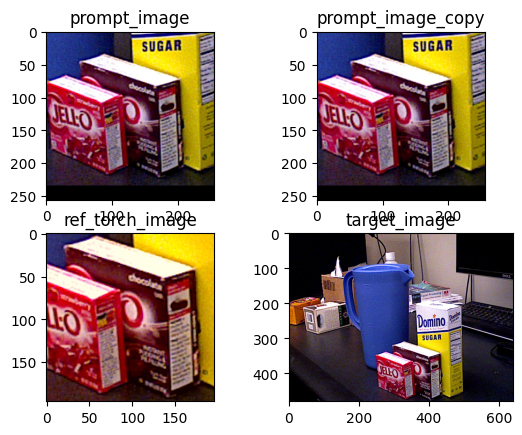

In [9]:
# 打印prompt_image，prompt_image_copy，反归一化后的ref_torch_image和target_image
plt.figure()

plt.subplot(221)
plt.title("prompt_image")
plt.imshow(cv2.cvtColor(prompt_image, cv2.COLOR_BGR2RGB))

plt.subplot(222)
plt.title("prompt_image_copy")
plt.imshow(cv2.cvtColor(prompt_image_copy, cv2.COLOR_BGR2RGB))

ref_torch_image_mean = np.array([0.485, 0.456, 0.406])
ref_torch_image_std = np.array([0.229, 0.224, 0.225])
plt.subplot(223)
plt.title("ref_torch_image")
plt.imshow(cv2.cvtColor(ref_torch_image[0].permute(1, 2, 0).cpu().numpy(), cv2.COLOR_BGR2RGB) * ref_torch_image_std + ref_torch_image_mean)

plt.subplot(224)
plt.title("target_image")
plt.imshow(cv2.cvtColor(target_image, cv2.COLOR_BGR2RGB))

plt.show()

In [10]:
image_h, image_w, _ = target_image.shape
t1 = time.time()
masks = MASK_GEN.generate(target_image)
t2 = time.time()
similarity_score, top_images = np.array([0, 0, 0], np.float32) , [[], [], []]
t3 = time.time()
compact_percent = 0.3

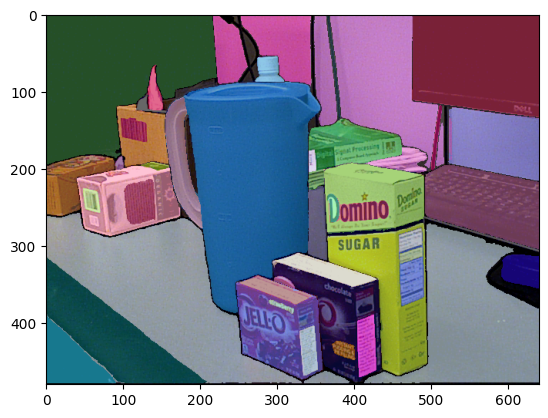

In [11]:
def render_mask(masks):
    if len(masks) == 0:
        return None
    res = np.zeros([masks[0]["segmentation"].shape[0], masks[0]["segmentation"].shape[1], 3])
    sorted_masks = sorted(masks, key=(lambda x: x["area"]), reverse=True)
    for mask in sorted_masks:
        m = mask["segmentation"]
        res[:, :, 0][m] = np.random.randint(0, 255)
        res[:, :, 1][m] = np.random.randint(0, 255)
        res[:, :, 2][m] = np.random.randint(0, 255)
    res = res.astype(np.uint8)
    return res

color_mask = render_mask(masks)
thres = 0.40
render_img = (target_image * thres + color_mask * (1 - thres)).astype(np.uint8)
plt.figure()
plt.imshow(cv2.cvtColor(render_img, cv2.COLOR_BGR2RGB))
plt.show()

In [12]:
target_image.shape, len(masks), type(masks[1]), [key for key in masks[1].keys()]

((480, 640, 3),
 45,
 dict,
 ['segmentation',
  'area',
  'bbox',
  'predicted_iou',
  'point_coords',
  'stability_score',
  'crop_box'])

In [13]:
masks[1]['segmentation'].shape, masks[1]['area'], masks[1]['bbox'], masks[1]['predicted_iou']

((480, 640), 9518, [40, 193, 133, 94], 1.0145248174667358)

In [14]:
masks[1]['point_coords'], masks[1]['stability_score'], masks[1]['crop_box']

([[60.0, 225.0]], 0.9828053116798401, [0, 0, 640, 480])

In [15]:
object_mask = np.expand_dims(masks[1]["segmentation"], -1)
x0, y0, w, h = masks[1]["bbox"]
x1, y1 = x0 + w, y0 + h
x0 -= int(w * compact_percent)
y0 -= int(h * compact_percent)
x1 += int(w * compact_percent)
y1 += int(h * compact_percent)
box = np.array([x0, y0, x1, y1])
resize_shape = np.array([y1 - y0, x1 - x0])
K_crop, K_crop_homo = get_K_crop_resize(box, K1, resize_shape)
image_crop, _ = get_image_crop_resize(target_image, box, resize_shape)
# object_mask, _ = get_image_crop_resize(object_mask, box, resize_shape)
box_new = np.array([0, 0, x1 - x0, y1 - y0])

In [16]:
object_mask.shape, x0, y0, x1, y1, box, resize_shape, K_crop.shape, K_crop_homo.shape, image_crop.shape, box_new

((480, 640, 1),
 1,
 165,
 212,
 315,
 array([  1, 165, 212, 315]),
 array([150, 211]),
 (3, 3),
 (3, 4),
 (150, 211, 3),
 array([  0,   0, 211, 150]))

(480, 640, 3)


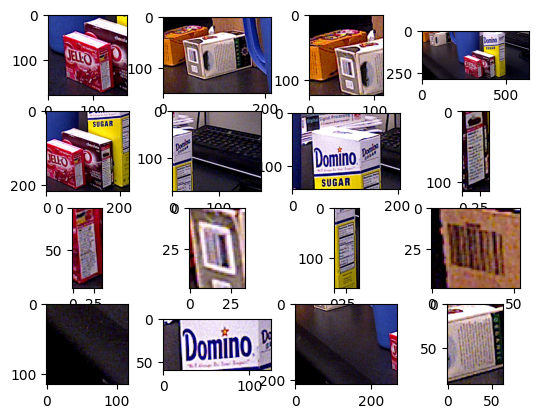

In [17]:
print(target_image.shape)
plt.figure()
for i in range(16 if len(masks) > 16 else len(masks)):
    x0, y0, w, h = masks[i]["bbox"]
    x1, y1 = x0 + w, y0 + h
    x0 -= int(w * compact_percent)
    y0 -= int(h * compact_percent)
    x1 += int(w * compact_percent)
    y1 += int(h * compact_percent)
    plt.subplot(4, 4, i+1)
    plt.imshow(cv2.cvtColor(target_image[y0 if y0 > 0 else 0:y1, x0 if x0 > 0 else 0:x1], cv2.COLOR_BGR2RGB))
plt.show()

In [18]:
# resize_shape = np.array([256, 256])
K_crop, K_crop_homo = get_K_crop_resize(box_new, K_crop, resize_shape)
image_crop, _ = get_image_crop_resize(image_crop, box_new, resize_shape)
crop_tensor = set_torch_image(image_crop, center_crop=True)
with torch.no_grad():
    fea = get_cls_token_torch(dinov2_model, crop_tensor)
# 从prompt_image中抽取ref_fea
# 从target_image中抽取fea
score = F.cosine_similarity(ref_fea, fea, dim=1, eps=1e-8)
if (score.item() > similarity_score).any():
    test_image_crop = image_crop
    test_K_crop = K_crop
    test_box = box
    min_idx = np.argmin(similarity_score)
    similarity_score[min_idx] = score.item()
    top_images[min_idx] = masks[0].copy()

In [19]:
resize_shape, K_crop, K_crop_homo

(array([150, 211]),
 array([[ 1.17713434e+03,  0.00000000e+00,  6.85027862e+01],
        [-3.96400122e-14,  1.17791669e+03, -2.05484524e+02],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]),
 array([[ 1.17713434e+03,  0.00000000e+00,  6.85027862e+01,
          0.00000000e+00],
        [-3.96400122e-14,  1.17791669e+03, -2.05484524e+02,
          0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
          0.00000000e+00]]))

In [20]:
for _, mask in enumerate(masks):
    object_mask = np.expand_dims(mask["segmentation"], -1)
    x0, y0, w, h = mask["bbox"]
    x1, y1 = x0 + w, y0 + h
    x0 -= int(w * compact_percent)
    y0 -= int(h * compact_percent)
    x1 += int(w * compact_percent)
    y1 += int(h * compact_percent)
    box = np.array([x0, y0, x1, y1])
    resize_shape = np.array([y1 - y0, x1 - x0])
    K_crop, K_crop_homo = get_K_crop_resize(box, K1, resize_shape)
    image_crop, _ = get_image_crop_resize(target_image, box, resize_shape)
    # object_mask, _ = get_image_crop_resize(object_mask, box, resize_shape)
    box_new = np.array([0, 0, x1 - x0, y1 - y0])
    if 'onepose' in dataset_path:
        resize_shape = np.array([512, 512])
    else:
        resize_shape = np.array([256, 256])
    K_crop, K_crop_homo = get_K_crop_resize(box_new, K_crop, resize_shape)
    image_crop, _ = get_image_crop_resize(image_crop, box_new, resize_shape)
    crop_tensor = set_torch_image(image_crop, center_crop=True)
    with torch.no_grad():
        fea = get_cls_token_torch(dinov2_model, crop_tensor)
    score = F.cosine_similarity(ref_fea, fea, dim=1, eps=1e-8)
    if (score.item() > similarity_score).any():
        mask["crop_image"] = image_crop
        mask["K"] = K_crop
        mask["bbox"] = box
        min_idx = np.argmin(similarity_score)
        similarity_score[min_idx] = score.item()
        top_images[min_idx] = mask.copy()

In [21]:
prompt_image = cv2.cvtColor(prompt_image, cv2.COLOR_BGR2GRAY)
prompt_image = torch.from_numpy(prompt_image).float()[None] / 255.
prompt_image = prompt_image.unsqueeze(0).cuda()

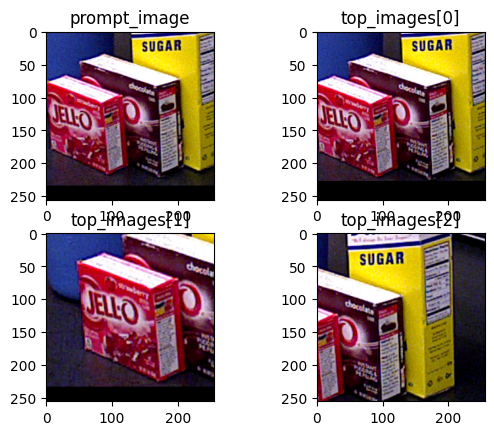

In [22]:
plt.figure()
plt.subplot(221)
plt.title("prompt_image")
plt.imshow(cv2.cvtColor(prompt_image_copy, cv2.COLOR_BGR2RGB))
for i in range(len(top_images)):
    plt.subplot(221+i+1)
    plt.title(f"top_images[{i}]")
    plt.imshow(cv2.cvtColor(top_images[i]["crop_image"], cv2.COLOR_BGR2RGB))
plt.show()

In [23]:
matching_score =  [[0] for _ in range(len(top_images))]
for top_idx in range(len(top_images)):
    img1 = cv2.cvtColor(top_images[top_idx]["crop_image"], cv2.COLOR_BGR2GRAY)
    img1 = torch.from_numpy(img1).float()[None] / 255.
    img1 = img1.unsqueeze(0).cuda()
    # print(prompt_image.shape, img1.shape)
    batch = {'image0':prompt_image, 'image1':img1}
    with torch.no_grad():
        matcher(batch)
        mkpts0 = batch['mkpts0_f'].cpu().numpy()
        mkpts1 = batch['mkpts1_f'].cpu().numpy()
        confidences = batch["mconf"].cpu().numpy()
    conf_mask = np.where(confidences > 0.9)
    matching_score[top_idx] = conf_mask[0].shape[0]
    top_images[top_idx]["mkpts0"] = mkpts0
    top_images[top_idx]["mkpts1"] = mkpts1
    top_images[top_idx]["mconf"] = confidences
    # mkpts0xmax, mkpts0ymax = np.max(mkpts0, axis=0)
    # mkpts1xmax, mkpts1ymax = np.max(mkpts1, axis=0)
    # print(mkpts0xmax, mkpts0ymax, mkpts1xmax, mkpts1ymax)

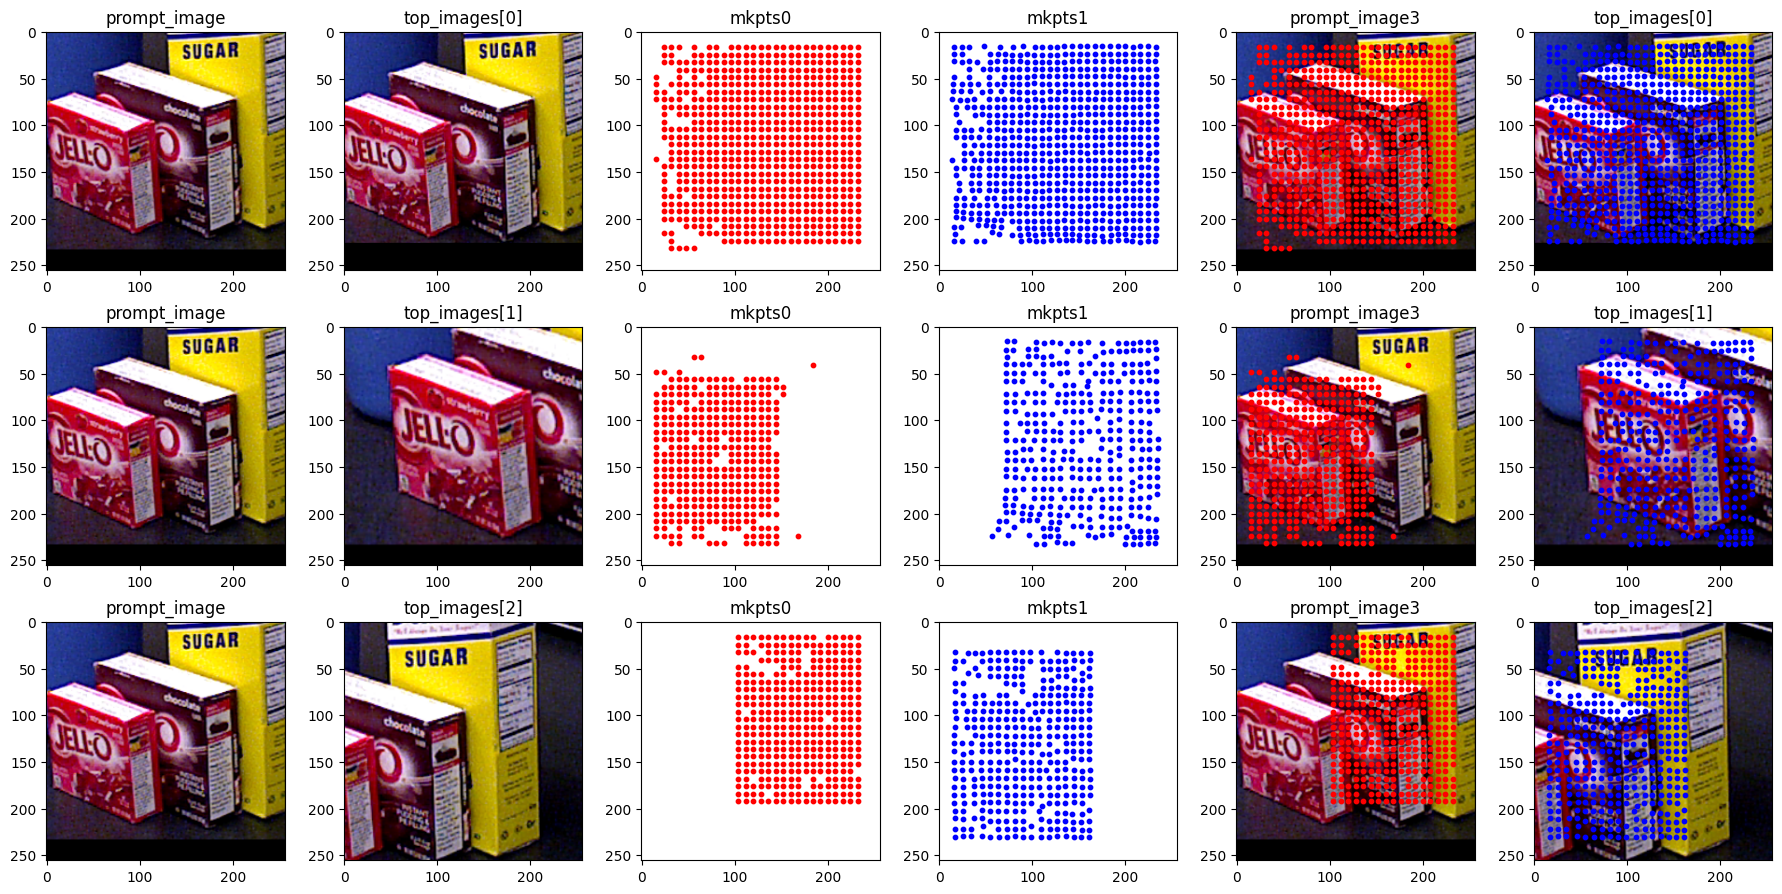

In [24]:
plt.figure(figsize=(18, 9))

blank_image = np.ones_like(prompt_image_copy)
blank_image *= 255

# 绘制子图
for i in range(len(top_images)):
    plt.subplot(len(top_images), 6, i*6+1)  # 第一列
    plt.title("prompt_image")
    plt.imshow(cv2.cvtColor(prompt_image_copy, cv2.COLOR_BGR2RGB))

for i in range(len(top_images)):
    plt.subplot(len(top_images), 6, i*6+2)  # 第二列
    plt.title(f"top_images[{i}]")
    plt.imshow(cv2.cvtColor(top_images[i]["crop_image"], cv2.COLOR_BGR2RGB))

for i in range(len(top_images)):
    plt.subplot(len(top_images), 6, i*6+3)  # 第三列
    plt.title(f"mkpts0")
    plt.imshow(blank_image)
    plt.scatter(top_images[i]["mkpts0"][:, 0], top_images[i]["mkpts0"][:, 1], c="r", s=10)

for i in range(len(top_images)):
    plt.subplot(len(top_images), 6, i*6+4)  # 第四列
    plt.title(f"mkpts1")
    plt.imshow(blank_image)
    plt.scatter(top_images[i]["mkpts1"][:, 0], top_images[i]["mkpts1"][:, 1], c="b", s=10)

for i in range(len(top_images)):
    plt.subplot(len(top_images), 6, i*6+5)  # 第五列
    plt.title("prompt_image3")
    plt.imshow(cv2.cvtColor(prompt_image_copy, cv2.COLOR_BGR2RGB))
    plt.scatter(top_images[i]["mkpts0"][:, 0], top_images[i]["mkpts0"][:, 1], c="r", s=10)

for i in range(len(top_images)):
    plt.subplot(len(top_images), 6, i*6+6)  # 第六列
    plt.title(f"top_images[{i}]")
    plt.imshow(cv2.cvtColor(top_images[i]["crop_image"], cv2.COLOR_BGR2RGB))
    plt.scatter(top_images[i]["mkpts1"][:, 0], top_images[i]["mkpts1"][:, 1], c="b", s=10)

plt.tight_layout()  # 自动调整子图布局，防止重叠
plt.show()

# for i in range(len(top_images)):
#     print(f"top_images[{i}]['mkpts0'].shape: {top_images[i]['mkpts0'].shape}")
#     print(f"top_images[{i}]['mkpts1'].shape: {top_images[i]['mkpts1'].shape}")
#     print(f"top_images[{i}]['mconf'].shape: {top_images[i]['mconf'].shape}")

In [25]:
matching_score

[617, 278, 308]

In [26]:
prompt_image_copy.shape, top_images[0]["crop_image"].shape

((256, 256, 3), (256, 256, 3))

In [27]:
cv2.resize(prompt_image_copy, (256, 256)).shape

(256, 256, 3)

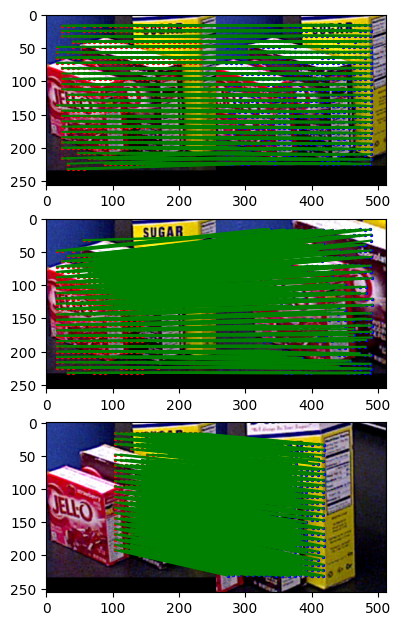

In [28]:
# if prompt_image_copy.shape[0] == 512:
#     prompt_image_copy = cv2.resize(prompt_image_copy, (256, 256))
#     for i in range(len(top_images)):
#         top_images[i]['mkpts0'] /= 2

plt.figure(figsize=(5, 7.5))
plt.axis("off")
for i in range(len(top_images)):
    plt.subplot(311+i)
    plt.imshow(cv2.cvtColor(np.concatenate((prompt_image_copy, top_images[i]["crop_image"]), axis=1), cv2.COLOR_BGR2RGB))
    plt.scatter(top_images[i]["mkpts0"][:, 0], top_images[i]["mkpts0"][:, 1], c="r", s=2)
    plt.scatter(top_images[i]["mkpts1"][:, 0] + 256, top_images[i]["mkpts1"][:, 1], c="b", s=2)
    for j in range(top_images[i]["mkpts0"].shape[0]):
        plt.plot([top_images[i]["mkpts0"][j, 0], top_images[i]["mkpts1"][j, 0] + 256], [top_images[i]["mkpts0"][j, 1], top_images[i]["mkpts1"][j, 1]], c="g", linewidth=1.5)
plt.show()

In [29]:
max_match_idx = np.argmax(matching_score)
pre_bbox  = top_images[max_match_idx]["bbox"]
mkpts0 = top_images[max_match_idx]["mkpts0"]
mkpts1 = top_images[max_match_idx]["mkpts1"]
pre_K = top_images[max_match_idx]["K"]

In [30]:
pre_bbox, type(mkpts0), mkpts0.shape, mkpts1.shape, pre_K

(array([252, 261, 477, 525]),
 numpy.ndarray,
 (698, 2),
 (698, 2),
 array([[ 1.33931730e+03, -5.02589402e-13, -2.07641274e+02],
        [ 0.00000000e+00,  1.34020743e+03, -3.65209059e+02],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]))

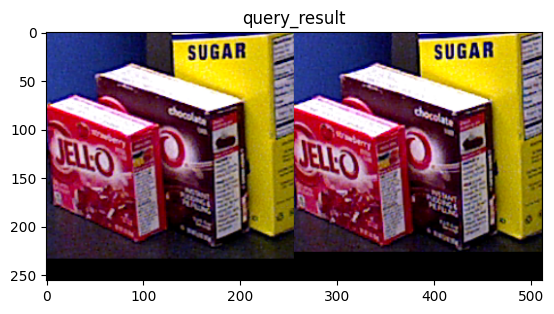

In [31]:
crop_image = cv2.resize(top_images[np.argmax(matching_score)]["crop_image"], (256, 256))
que_image = cv2.resize(prompt_image_copy, (256, 256))
segment_mask = (255 * top_images[np.argmax(matching_score)]["segmentation"]).astype(np.uint8)
stack_result_image = np.hstack((que_image, crop_image))
# cv2.imwrite("query_result.png", stack_result_image)
plt.figure()
plt.title("query_result")
plt.imshow(cv2.cvtColor(stack_result_image, cv2.COLOR_BGR2RGB))
plt.show()
# 估计出了两个小图之间的旋转和位移
R, t, inliers = estimate_pose(mkpts0, mkpts1, K0, pre_K, 0.5, 0.99)

In [32]:
prompt_pose, target_pose

(array([[ 6.37904486e-01,  2.80719430e-01, -7.17129613e-01,
          3.57205294e+01],
        [ 5.86359745e-01, -7.80731416e-01,  2.15965646e-01,
          9.80161108e+01],
        [-4.99259795e-01, -5.58261066e-01, -6.62634358e-01,
          7.48030189e+02]]),
 array([[ 6.42451304e-01,  2.77351031e-01, -7.14376065e-01,
          3.51886382e+01],
        [ 5.80043513e-01, -7.85207322e-01,  2.16793103e-01,
          1.02198073e+02],
        [-5.00805950e-01, -5.53647241e-01, -6.65332859e-01,
          7.39012288e+02]]))

In [33]:
predict_pose = np.zeros((3, 4)).astype(np.float32)
# 将相对旋转作用到prompt_pose的旋转上
predict_pose[:3, :3] = np.matmul(R, prompt_pose[:3, :3])
our_predict_pose = predict_pose[:3, :3].copy()
# target_pose中的位移不会改变，直接赋值给predict_pose
predict_pose[:3, 3] = target_pose[:3, 3]
# 将3Dbbox根据predict_pose和target视角下的内参投影到2D平面上
pre_bbox_pts_3d, _ = project_points(_3d_bbox, predict_pose[:3, :4], K1)
pre_bbox_pts_3d = pre_bbox_pts_3d.astype(np.int32)

pre_bbox_pts_3d_gt, _ = project_points(_3d_bbox, target_pose[:3, :4], K1)
pre_bbox_pts_3d_gt = pre_bbox_pts_3d_gt.astype(np.int32)

In [34]:
pre_bbox_pts_3d, pre_bbox_pts_3d_gt

(array([[132, 131],
        [103, 131],
        [107, 101],
        [136, 102],
        [144, 143],
        [114, 143],
        [118, 112],
        [148, 112]], dtype=int32),
 array([[121, 118],
        [ 99, 128],
        [108, 105],
        [130,  96],
        [142, 138],
        [120, 149],
        [130, 126],
        [152, 116]], dtype=int32))

2024-05-08 10:58:00.345555


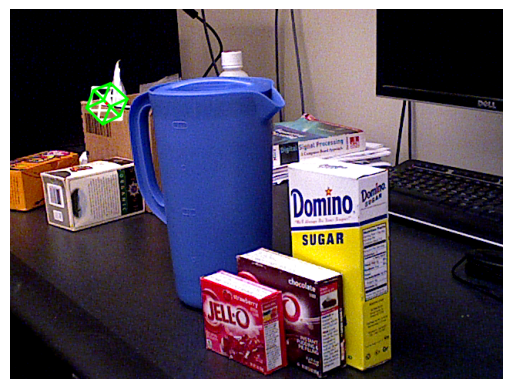

In [35]:
from datetime import datetime
print(datetime.now())

target_image_copy = target_image.copy()

our_bbox_img = draw_bbox_3d(target_image, pre_bbox_pts_3d, (255, 255, 255))
our_bbox_img = draw_axis(our_bbox_img, predict_pose[:3, :3], predict_pose[:3, 3], K1)

our_bbox_img_gt = draw_bbox_3d(target_image_copy, pre_bbox_pts_3d, (255, 255, 255))
our_bbox_img_gt = draw_axis(our_bbox_img_gt, predict_pose[:3, :3], predict_pose[:3, 3], K1)
our_bbox_img_gt = draw_bbox_3d(target_image_copy, pre_bbox_pts_3d_gt, (0, 255, 0))
our_bbox_img_gt = draw_axis(our_bbox_img_gt, target_pose[:3, :3], target_pose[:3, 3], K1)
# cv2.imwrite(f"3D_BBox.png", our_bbox_img)
plt.figure()
plt.axis('off')

# plt.subplot(121)
# plt.title("3D_BBox")
# plt.imshow(cv2.cvtColor(our_bbox_img, cv2.COLOR_BGR2RGB))

# plt.subplot(122)
# plt.title("3D_BBox_gt")
plt.imshow(cv2.cvtColor(our_bbox_img_gt, cv2.COLOR_BGR2RGB))

plt.show()
# cv2.imwrite(f'3D_BBox_pope-{prompt}-{target}.png', our_bbox_img_gt)

In [36]:
cv2.imwrite(f'res_img/{prompt}-{target}-onepose_plusplus-pope.png', our_bbox_img_gt)

True